In [11]:
# dataset link: https://www.kaggle.com/competitions/birdclef-2021/data

import os

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import numpy as np
import torch
from PIL import Image
from sklearn.utils import shuffle
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# Global vars
RANDOM_SEED = 420
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 30 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
NUM_TAKEN_FROM_SPECIES = 100

In [2]:
# Code adapted from: 
# https://www.kaggle.com/frlemarchand/bird-song-classification-using-an-efficientnet
# Make sure to check out the entire notebook.

# Load metadata file
train = pd.read_csv('train_metadata.csv',)

# Limit the number of training samples and classes
# First, only use high quality samples
train = train.query('rating>=4')

# Second, assume that birds with the most training samples are also the most common
# A species needs at least MIN_RECORDINGS recordings with a rating above 4 to be considered common

MIN_RECORDINGS = 100

birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= MIN_RECORDINGS] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 132
NUMBER OF SAMPLES IN TRAIN DATA: 22784
LABELS: ['acowoo', 'amecro', 'amered', 'amerob', 'andsol1', 'astfly', 'azaspi1', 'banana', 'barant1', 'barswa', 'baywre1', 'bcnher', 'belvir', 'bewwre', 'bkbplo', 'bkcchi', 'bkhgro', 'bkmtou1', 'blbgra1', 'blujay', 'bncfly', 'bobfly1', 'brratt1', 'buggna', 'burwar1', 'butsal1', 'cangoo', 'carwre', 'caskin', 'ccbfin', 'chbant1', 'chcant2', 'chispa', 'clcrob', 'cobtan1', 'coltro1', 'compau', 'comrav', 'comyel', 'cubthr', 'daejun', 'ducfly', 'easmea', 'eastow', 'eucdov', 'eursta', 'fepowl', 'gbwwre1', 'gnwtea', 'grasal1', 'greegr', 'grekis', 'grethr1', 'grhowl', 'grtgra', 'grycat', 'gwfgoo', 'hergul', 'herthr', 'houfin', 'houspa', 'houwre', 'hutvir', 'indbun', 'killde', 'laufal1', 'lesgol', 'lesvio1', 'linspa', 'littin1', 'lobgna5', 'macwar', 'mallar3', 'marwre', 'meapar', 'mutswa', 'norcar', 'norfli', 'normoc', 'norwat', 'obnthr1', 'oliwoo1', 'orcwar', 'ovenbi1', 'pabspi1', 'pirfly1', 'plaxen1', 'plupig2', 'rcata

In [3]:
sigd, rated = librosa.load("/Users/matthewho/Photonic_computing/audio/train_short_audio/acafly/XC109605.ogg", sr = SAMPLE_RATE, offset = None)
np.size(sigd) / SAMPLE_RATE

NameError: name 'librosa' is not defined

In [4]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)

# Define a function that splits an audio file, 
# extracts spectrograms and saves them in a working directory
def get_spectrograms(filepath, primary_label, output_dir):
    
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None)

    # randomly select 30 second interval: see https://github.com/ChristofHenkel/kaggle-birdclef2021-2nd-place/blob/26438069466242e9154aacb9818926dba7ddc7f0/data/ps_ds_8.py#L92
    call_length = np.size(sig) / SAMPLE_RATE
    max_offset = SIGNAL_LENGTH - call_length
    offset = np.random.randint(max(max_offset, 0) + 1)
    
    # repeat the audio as necessary
    min_length = SAMPLE_RATE * SIGNAL_LENGTH

    sig_regulated = np.copy(sig)
    while min_length > np.size(sig_regulated) + np.size(sig):
        sig_regulated = np.concatenate(sig_regulated, sig)
    sig_regulated = sig_regulated[:min_length]
    
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
    mel_spec = librosa.feature.melspectrogram(y=sig_regulated, 
                                              sr=SAMPLE_RATE, 
                                              n_fft=1024, 
                                              hop_length=hop_length, 
                                              n_mels=SPEC_SHAPE[0], 
                                              fmin=FMIN, 
                                              fmax=FMAX)

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
    
    # Normalize
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()
    
    # Save as image file
    save_dir = os.path.join(output_dir, primary_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + '.png')
    im = Image.fromarray(mel_spec * 255.0).convert("L")
    im.save(save_path)
    
    return save_path

print('NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TRAIN))

NUMBER OF AUDIO FILES IN TRAINING DATA: 22784


In [5]:
# # This only has to be run once

# # # Parse audio files and extract training samples
# input_dir = 'train_short_audio/'
# output_dir = 'spectrogram_folder/'
# samples = []
# with tqdm(total=len(TRAIN)) as pbar:
#     for idx, row in TRAIN.iterrows():
#         pbar.update(1)
        
#         if row.primary_label in most_represented_birds:
#             audio_file_path = os.path.join(input_dir, row.primary_label, row.filename)
#             samples.append(get_spectrograms(audio_file_path, row.primary_label, output_dir))
            
# TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
# print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

In [6]:
def accumulate_file_paths(directory):
    file_paths = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    return file_paths

directory_path = 'spectrogram_folder'
samples = accumulate_file_paths(directory_path)

TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)

For simplicity, we are not going to use soundscapes, and are going to only perform metalearning on the recordings in train_short_audio only. We first partition the data such that each class (bird species) has exactly the same number of spectrograms.

In [7]:
def get_species_from_spec_path(path):
    return path.split('/')[1]

birb_count = {}
for spec_path in TRAIN_SPECS:
    birb_name = get_species_from_spec_path(spec_path)
    if birb_name in birb_count:
        birb_count[birb_name] += 1
    else:
        birb_count[birb_name] = 1
        
# min number of spectrograms
print(f"minimum number of spectrograms per bird: {min(list(map(lambda x: x[1], birb_count.items())))}")

minimum number of spectrograms per bird: 100


spectrogram_folder/whcspa/XC416339.png
spectrogram_folder/obnthr1/XC166598.png
spectrogram_folder/rewbla/XC407824.png
spectrogram_folder/sonspa/XC330068.png
spectrogram_folder/amerob/XC569292.png
spectrogram_folder/carwre/XC469529.png
spectrogram_folder/houspa/XC168649.png
spectrogram_folder/caskin/XC493351.png
spectrogram_folder/easmea/XC296495.png
spectrogram_folder/roahaw/XC117302.png
spectrogram_folder/azaspi1/XC578337.png
spectrogram_folder/amerob/XC381537.png


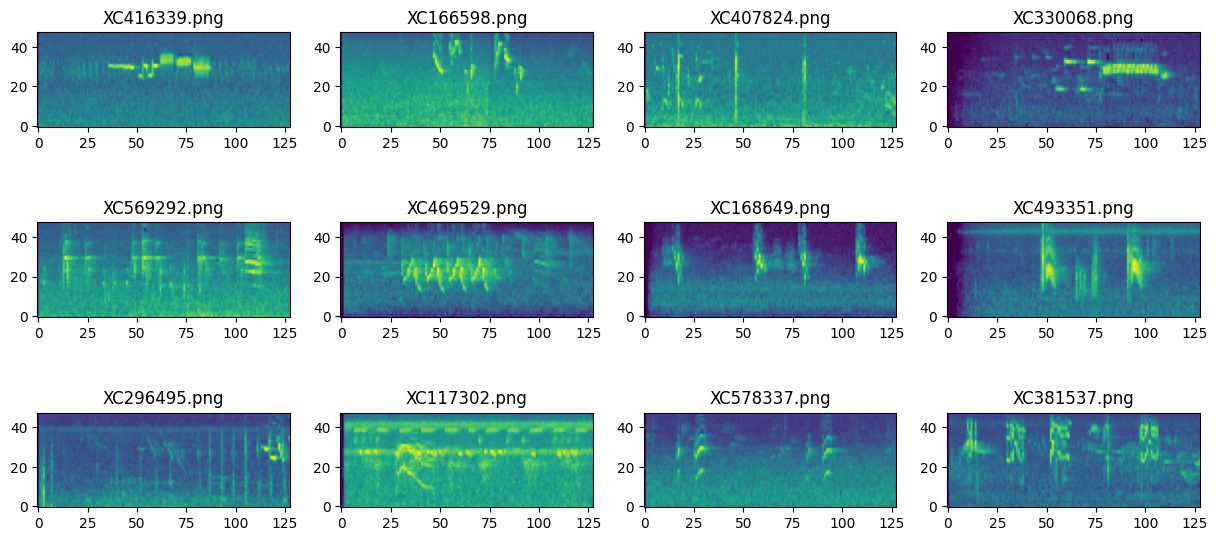

In [8]:
# Plot the first 12 spectrograms of TRAIN_SPECS
plt.figure(figsize=(15, 7))
for i in range(12):
    print(TRAIN_SPECS[i])
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

We will randomly select 100 spectrograms per bird to make the dataset balanced. We will split the 132 species of birds covered here into 80 birds for training and 52 birds for testing, and will select 5 classes of birds at a time to do 5-way classification.

In [9]:
TRAIN_SPECS[0]

'spectrogram_folder/whcspa/XC416339.png'

In [10]:
len(birb_count)

132

In [11]:
samples.sort()
selected_samples = []

sample_idx = 0
for birb in sorted(list(birb_count.keys())):
    selections = random.sample(range(0, birb_count[birb]), NUM_TAKEN_FROM_SPECIES)
    for selection in selections:
        selected_samples.append(samples[sample_idx + selection])
    sample_idx += birb_count[birb]

In [12]:
print(len(selected_samples))

13200


We create a dictionary from birb names to indices and vice versa for ease of usage.

In [13]:
birb_to_idx = {}
idx_to_birb = {}

for idx, birb in enumerate(sorted(list(birb_count.keys()))):
    idx_to_birb[idx] = birb
    birb_to_idx[birb] = idx

Now, selected_samples contains the paths to all of the birds that we will use for metalearning.

In [129]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def create_sets(birbs, train_ratio = 0.8, cv_ratio = 0.1, test_ratio = 0.1):
    assert train_ratio + cv_ratio + test_ratio == 1
    x_train, x_cv, x_test = [], [], []
    y_train, y_cv, y_test = [], [], []
    for label, birb in enumerate(birbs):
        samples = selected_samples[birb * NUM_TAKEN_FROM_SPECIES:  (birb + 1) * NUM_TAKEN_FROM_SPECIES]
        random.shuffle(samples)
        for sample_idx in range(round(train_ratio * NUM_TAKEN_FROM_SPECIES)):
            # add samples[sample_idx]
            x_train.append(np.array(Image.open(samples[sample_idx])))
            y_train.append(label)
        for sample_idx in range(round(cv_ratio * NUM_TAKEN_FROM_SPECIES)):
            x_cv.append(np.array(Image.open(samples[sample_idx + round(NUM_TAKEN_FROM_SPECIES * train_ratio)])))
            y_cv.append(label)
        for sample_idx in range(round(test_ratio * NUM_TAKEN_FROM_SPECIES)):
            x_test.append(np.array(Image.open(samples[sample_idx + round(NUM_TAKEN_FROM_SPECIES * (train_ratio + cv_ratio))])))
            y_test.append(label)

    
    x_train = np.array(x_train).astype(np.float32)
    y_train = np.array(y_train).astype(np.float32)
    x_cv = np.array(x_cv).astype(np.float32)
    y_cv = np.array(y_cv).astype(np.float32)
    x_test = np.array(x_test).astype(np.float32)
    y_test = np.array(y_test).astype(np.float32)


    train_perm = np.random.permutation(len(x_train))
    cv_perm = np.random.permutation(len(x_cv))
    test_perm = np.random.permutation(len(x_test))

    x_train = x_train[train_perm]
    y_train = y_train[train_perm]
    x_cv = x_cv[cv_perm]
    y_cv = y_cv[cv_perm]
    x_test = x_test[test_perm]
    y_test = y_test[test_perm]

    x_train = torch.from_numpy(x_train).to(torch.device('cpu'))
    y_train = torch.from_numpy(y_train).to(torch.device('cpu'))
    x_cv = torch.from_numpy(x_cv).to(torch.device('cpu'))
    y_cv = torch.from_numpy(y_cv).to(torch.device('cpu'))
    x_test = torch.from_numpy(x_test).to(torch.device('cpu'))
    y_test = torch.from_numpy(y_test).to(torch.device('cpu'))

    
    return x_train, y_train, x_cv, y_cv, x_test, y_test

In [130]:
# modify to actually use batches so batch_norm is a thing

def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = nn.Sequential(
    nn.Conv2d(1, 32, 7, padding = 3),
    nn.ReLU(),
    nn.Conv2d(32, 16, 5, padding = 2),
    nn.ReLU(),
    nn.Conv2d(16, 8, 3, padding = 1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(8 * 48 * 128, 5)
)

In [154]:
import datetime

def check_accuracy(x, y, model, show_preds = False):
    # print('Checking accuracy on set')   
    num_correct = 0
    num_samples = 0
    num_data_points = x.shape[0]
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=torch.device("cpu"), dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=torch.device("cpu"), dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)
        if show_preds:
            print(f"preds are: {preds}")
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

def train(x_train, y_train, x_cv, y_cv, model, optimizer, epochs=50):
    model = model.to(device=torch.device("cpu"))  # move the model parameters to CPU/GPU
    best_model = deepcopy(model)
    cv_accs = []
    for e in range(epochs):
        
        model.train()  # put model to training mode
        x = x_train.to(device=torch.device("cpu"), dtype=torch.float32)  # move to device, e.g. GPU
        y = y_train.to(device=torch.device("cpu"), dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        cv_acc = check_accuracy(x_cv, y_cv, model)
        
        if e % 50 == 0:
            print(f"Epoch {e}")
        
        cv_accs.append(cv_acc)

        if cv_acc == max(cv_accs):
            best_model = deepcopy(model)
    return cv_accs, best_model


In [155]:
models = []
birbs_selected = []
cv_accs_collection = []
test_accuracies = []
lr = 1e-2

for iter in range(30):
    current_time = datetime.datetime.now()
    print(f"On iteration {iter}:, and current time: {current_time}")
    model = nn.Sequential(
        nn.Conv2d(1, 32, 7, padding = 3),
        nn.ReLU(),
        nn.Conv2d(32, 16, 5, padding = 2),
        nn.ReLU(),
        nn.Conv2d(16, 8, 3, padding = 1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(8 * 48 * 128, 5)
    )
    random_birbs = random.sample(range(132), 5)
    birbs_selected.append(random_birbs)
    x_train, y_train, x_cv, y_cv, x_test, y_test = create_sets(random_birbs)
    
    train_mean = torch.mean(x_train)
    train_std = torch.std(x_train)
    
    x_train = (x_train - train_mean)/(train_std)
    x_cv = (x_cv - train_mean)/(train_std)
    x_test = (x_test - train_mean)/(train_std)
    
    x_train = torch.unsqueeze(x_train, 1)
    x_cv = torch.unsqueeze(x_cv, 1)
    x_test = torch.unsqueeze(x_test, 1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    cv_acc, best_model = train(x_train, y_train, x_cv, y_cv, model, optimizer, epochs = 100)
    cv_accs_collection.append(cv_acc)
    models.append(best_model)
    print(cv_accs_collection[-1])
    test_acc = check_accuracy(x_test, y_test, best_model)
    test_accuracies.append(test_acc)
    print(f"Test accuracy: {test_acc}")

On iteration 0:, and current time: 2023-08-18 02:26:39.071163
Epoch 0
Epoch 50
[0.28, 0.28, 0.3, 0.3, 0.32, 0.26, 0.28, 0.26, 0.36, 0.32, 0.22, 0.2, 0.2, 0.18, 0.22, 0.2, 0.28, 0.28, 0.26, 0.22, 0.24, 0.24, 0.22, 0.26, 0.26, 0.26, 0.22, 0.22, 0.2, 0.22, 0.28, 0.26, 0.3, 0.26, 0.26, 0.3, 0.4, 0.3, 0.36, 0.44, 0.48, 0.52, 0.46, 0.54, 0.36, 0.48, 0.36, 0.58, 0.54, 0.4, 0.56, 0.58, 0.54, 0.46, 0.5, 0.52, 0.5, 0.48, 0.42, 0.54, 0.48, 0.46, 0.44, 0.44, 0.46, 0.5, 0.4, 0.54, 0.56, 0.54, 0.52, 0.52, 0.52, 0.5, 0.52, 0.52, 0.5, 0.46, 0.44, 0.48, 0.52, 0.5, 0.5, 0.5, 0.5, 0.54, 0.46, 0.5, 0.48, 0.46, 0.5, 0.48, 0.48, 0.48, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46]
Test accuracy: 0.42
On iteration 1:, and current time: 2023-08-18 02:35:31.177039
Epoch 0
Epoch 50
[0.36, 0.32, 0.42, 0.48, 0.46, 0.5, 0.46, 0.26, 0.46, 0.18, 0.18, 0.18, 0.18, 0.2, 0.2, 0.2, 0.34, 0.38, 0.54, 0.48, 0.38, 0.38, 0.26, 0.3, 0.3, 0.3, 0.32, 0.28, 0.36, 0.46, 0.42, 0.48, 0.5, 0.54, 0.54, 0.58, 0.58, 0.58, 0.64, 0.6, 0.6, 0.6, 0.

In [158]:
np.mean(test_accuracies)

0.5106666666666666

In [164]:
np.mean(np.array(list(map(lambda x: x[-1], cv_accs_collection))))

0.344

In [9]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 12.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [10]:
test = np.ones((100,100))
import cv2
test1 = cv2.resize(test, None, fx = 10/100, fy = 10/100)
test1.shape

(10, 10)